# FFTW and FFTs

這一節，我們介紹如何使用 package FFTW。

In [1]:
using FFTW
using LinearAlgebra
using Plots

## Section 1 - Fast Fourier Transform(fft) 的輸入方式
fft 是一個將函數值轉成傅立葉係數的指令，因此，我們在 fft() 的括號裡放入函數值所形成的向量。

### section 1.1 - 1D fft

當資料是一維的時候輸入行向量或列向量，結果是一樣的。如以下兩個例子：

In [2]:
fft([0; 1; 2; 1])

4-element Array{Complex{Float64},1}:
  4.0 + 0.0im
 -2.0 + 0.0im
  0.0 + 0.0im
 -2.0 + 0.0im

In [3]:
fft([0, 1, 2, 1])

4-element Array{Complex{Float64},1}:
  4.0 + 0.0im
 -2.0 + 0.0im
  0.0 + 0.0im
 -2.0 + 0.0im

### section 1.2 - 2D fft

當資料是個矩陣時，julia 中的 fft 則是對這矩陣做二維的 fft。

**注意：** Matlab 中對矩陣做二維 fft 的指令是 fft2。

如以下例子：

In [4]:
A=[0 0 0 0; 1 1 1 1; 2 2 2 2; 1 1 1 1]

4×4 Array{Int64,2}:
 0  0  0  0
 1  1  1  1
 2  2  2  2
 1  1  1  1

In [5]:
fft(A)

4×4 Array{Complex{Float64},2}:
 16.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im
 -8.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im
  0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im
 -8.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im

從結果可以看出 Julia 的 fft 指令做矩陣的傅立葉轉換時，是先做行向量，並將結果依照行向量儲存在該行。全部做完一次之後再做列向量，再將該列的結果儲存在該列。 

我們把步驟拆解開來看，

1. 上例中，先做 fft([0;1;2;1]) = [4;-2;0;-2]。矩陣中四行都做完會得到

In [6]:
[4 4 4 4; -2 -2 -2 -2; 0 0 0 0; -2 -2 -2 -2]

4×4 Array{Int64,2}:
  4   4   4   4
 -2  -2  -2  -2
  0   0   0   0
 -2  -2  -2  -2

2. 接下來再做列向量。由於現在每一列都是常數函數，所以我們可以預期它的結果只有在第一個傅立葉係數有值，其他為 0。(第一個傅立葉係數 $\hat{f}_0$ 儲存的是函數常數的部分，也就是 $e^0$ 的係數)。底下是 f(x) = 4 的傅立葉轉換結果，結果是 $4 \times N$，$N$ 是取點的各數，在這裡是取樣 4 個點 (細節在稍後的小節中會提到)。其他列的計算結果雷同，fft([-2 -2 -2 -2]) = [-8 0 0 0], fft([0 0 0 0]) = [0 0 0 0]。

In [7]:
fft([4 4 4 4])

1×4 Array{Complex{Float64},2}:
 16.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im

把每一列的結果按照每一列的順序排好就會得到

In [8]:
[16 0 0 0; -8 0 0 0; 0 0 0 0; -8 0 0 0]

4×4 Array{Int64,2}:
 16  0  0  0
 -8  0  0  0
  0  0  0  0
 -8  0  0  0

## Section 2 - FFT 的運算時間
下列的兩個例子告訴我們，fft 這個內建的函數運算速度很快，將一個 (2^17)*1 的向量轉成傅立葉係數不會超過 0.2 秒。另一個需要注意的地方是當我們使用 @time 計算運算時間時，需要多算幾次再取平均。

如果向量的長度為 2 的倍數，運算速度會比較快

In [9]:
x = randn(2^17)
@time y = fft(x);
x = randn(2^17)
@time y = fft(x);
x = randn(2^17)
@time y = fft(x);
x = randn(2^17)
@time y = fft(x);

  0.044618 seconds (72.50 k allocations: 7.745 MiB, 13.55% gc time)
  0.004081 seconds (58 allocations: 4.003 MiB)
  0.009898 seconds (58 allocations: 4.003 MiB, 51.67% gc time)
  0.003788 seconds (58 allocations: 4.003 MiB)


如果向量的長度不是 2 的倍數，運算速度會比較慢

In [10]:
x = randn(92993)
@time y = fft(x);
x = randn(92993)
@time y = fft(x);
x = randn(92993)
@time y = fft(x);
x = randn(92993)
@time y = fft(x);

  0.033021 seconds (58 allocations: 2.841 MiB)
  0.023053 seconds (58 allocations: 2.841 MiB)
  0.028302 seconds (58 allocations: 2.841 MiB)
  0.025895 seconds (58 allocations: 2.841 MiB, 16.26% gc time)


## Section 3 - FFT 的運算量
FFT 的運算量約為 nlog(n), n 為向量長度。

```diff
- TS: 為什麼需要 "for ii" 這個回圈? 
-     cpt 這個函數也需要解釋一下
```

In [11]:
function cpt(k)
    for ii = 1:1
        x = randn(10^k);
        y = fft(x);
    end
end

cpt (generic function with 1 method)

用 @timed 計時可以把時間存起來，@timed 的運算結果是一個向量，計算時間儲存在向量的第二個值。

我們把 n = $10^2$ ~ $10^8$ 計算的結果分別儲存在 x2 ~ x8 中。

In [12]:
@timed cpt(8)

(nothing, 23.634766795, 4000887327, 0.291171846, Base.GC_Diff(4000887327, 3, 0, 14804, 0, 0, 291171846, 4, 3))

In [13]:
x2 = @timed cpt(2);
x3 = @timed cpt(3);
x4 = @timed cpt(4);
x5 = @timed cpt(5);
x6 = @timed cpt(6);
x7 = @timed cpt(7);
x8 = @timed cpt(8);

(nothing, 15.736861946, 4000003424, 0.301343274, Base.GC_Diff(4000003424, 3, 0, 57, 0, 0, 301343274, 3, 3))

為了方便畫圖，我們把計算的時間存在 y1 中，y2為 nlog(n)，n = $10^2$ ~ $10^8$。

In [14]:
y1 = [x2[2], x3[2], x4[2], x5[2], x6[2], x7[2], x8[2]];

In [15]:
y2 = [2*10^2, 3*10^3, 4*10^4, 5*10^5, 6*10^6, 7*10^7, 8*10^8];

In [16]:
x = [10^2, 10^3, 10^4, 10^5, 10^6, 10^7, 10^8];

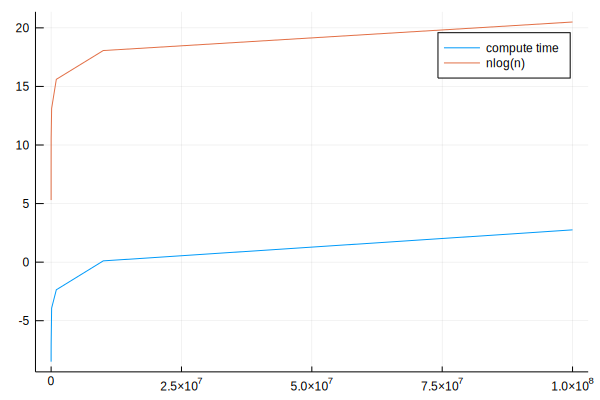

In [17]:
p = plot(x,log.(y1),label="compute time")
plot!(p,x,log.(y2),label="nlog(n)")

我們將計算所花的時間和 nlog(n) 分別取對數畫在同一張圖上，會發現斜率幾乎一樣。因此 fft 的運算量約為 nlog(n)。

補充：

我們可以利用 varinfo() 查看所有變數

In [18]:
varinfo()

| name |       size | summary                                           |
|:---- | ----------:|:------------------------------------------------- |
| A    |  168 bytes | 4×4 Array{Int64,2}                                |
| Base |            | Module                                            |
| Core |            | Module                                            |
| Main |            | Module                                            |
| cpt  |    0 bytes | typeof(cpt)                                       |
| p    | 34.366 KiB | Plots.Plot{Plots.GRBackend}                       |
| x    |   96 bytes | 7-element Array{Int64,1}                          |
| x2   |   96 bytes | Tuple{Nothing,Float64,Int64,Float64,Base.GC_Diff} |
| x3   |   96 bytes | Tuple{Nothing,Float64,Int64,Float64,Base.GC_Diff} |
| x4   |   96 bytes | Tuple{Nothing,Float64,Int64,Float64,Base.GC_Diff} |
| x5   |   96 bytes | Tuple{Nothing,Float64,Int64,Float64,Base.GC_Diff} |
| x6   |   96 bytes | Tuple{Nothing,Float64,Int64,Float64,Base.GC_Diff} |
| x7   |   96 bytes | Tuple{Nothing,Float64,Int64,Float64,Base.GC_Diff} |
| x8   |   96 bytes | Tuple{Nothing,Float64,Int64,Float64,Base.GC_Diff} |
| y    |  1.419 MiB | 92993-element Array{Complex{Float64},1}           |
| y1   |   96 bytes | 7-element Array{Float64,1}                        |
| y2   |   96 bytes | 7-element Array{Int64,1}                          |


## Section 4 - fft 的準確度
下列兩個例子告訴我們，使用 fft 求傅立葉係數的誤差會在機器誤差 ($10^{-14}$) 以下。

我們將要轉換的值儲存在變數 a 中，利用 fft(a) 取其傅立葉係數，再利用 ifft(fft(a)) 轉回原來的函數值。

如果 fft 與 ifft 這兩個函數可以很準確的把函數值轉成傅立葉係數，再轉回原函數，那麼 ifft(fft(a)) 與 a 的值差距應該要很小。

因此我們用 norm 計算 ifft(fft(a)) 與 a 之間的誤差。下列兩個結果顯示，轉換的誤差會小於機器誤差。

Julia 中，norm 這個函數可以用來算向量與矩陣的範數，

norm(A, Inf) 用來計算 A 的 infinity norm，即取出向量中絕對值最大的元素。

norm(A, p) 用來計算 A 的 p norm，$||A||_p = (\sum_{i = 1}^n |a_i|^p)^{1/p}$，其中 $a_i$ 是 A 中的元素，A 的長度為 n。

norm(A) 是用預設的值，算的是 2 - norm。

我們用兩個例子來檢驗。令 a 是複數，實部與虛部都取亂數。
1. rand(8) 是從 0 到 1 之間取 8 個亂數，值為小數。
2. rand(-10:10,8) 是從 -10 到 10 之間取 8 個亂數，值為整數。

In [19]:
a = rand(8) + im*rand(8);
norm(ifft(fft(a)) - a)

1.1102230246251565e-16

In [20]:
a = rand(-10:10, 8) + im*rand(-10:10, 8);
norm(ifft(fft(a)) - a)

2.275280134513746e-15